# Install relevant libraries
I use the pip python package manager to install the relevant modeules for this analysis. Modules already present in the Anaconda distribution are optional to install. 

In [2]:
#LIBRARIES NOT IN ANACONDA DISTRIBUTION
#!pip install missingno
#!pip install category_encoders
#!pip install imblearn
#!pip install yellowbrick
#!pip install xgboost
#!pip install sweetviz
#!pip install rfpimp
#pip install joblib

#LIBRARIES IN ANACONDA DISTRIBUTION
#!pip install numpy
#!pip install pandas
#!pip install matplotlib
#pip install seaborn
#pip install datetime
#pip install warnings

# Imports
In this code block, I import the modules that will be used for the analysis. These include modules for data analysis, model building and for saving the model. I have kept all imports at the top for easy reference.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno

# Data analysis
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from datetime import datetime
import sweetviz as sv
from sklearn.neighbors import LocalOutlierFactor

# Model Building
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, f1_score
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from yellowbrick.features import RFECV
from yellowbrick.classifier import ConfusionMatrix, ROCAUC
from yellowbrick.model_selection import LearningCurve
from sklearn.dummy import DummyClassifier

#Libraries for Saving the Model
import joblib

#others
import warnings
import requests

#set a random state (seed) to be used throughout the analysis for repeatablity
seed = 1
warnings.filterwarnings('ignore')

# Read the dataset into a pandas dataframe 

The loan default data is read into a pandas dataframe for analysis. Although the data was saved in a CSV file format, it is of Tab-Delimited form meaning that each data attribute is separated by a tab space. The original dataframe is stored in case I need to return to it later after making some intermediate transformations. There is an unnamed attribute in the dataset which represents the index. This attribute is dropped

In [6]:
#read the file into a pandas dataframe
url = ("../data/homework-data-Olaoluwapo-Oyefolu.csv")
df = pd.read_csv(url, sep='\t')
df = df.drop(columns=[ "Unnamed: 0"])
orig_df = df.copy()

# Explore data analysis
I used the sweetviz module to perform exploratory data analysis. It performs extensive exploratory data analysis (central tendency, spread, bar charts, missing data analysis, correlation) on the entire dataframe and exports the results of the analysis as an interactive HTML-5 file. A static version is stored as well. If it shows "Error displaying widget" on the output of this ipynb, please ignore it, **the interactive web page will pop up as a new tab on your browser when it is done running**. The column names are too long do be displayed legibly in the sweetviz correlation matrix. Thus, I have written a script to reduce the names to just the last part (after the 4th dot) for the relevant columns. I have added a numerical suffix in the cases where a name is duplicated.




In [8]:
#get the list of columns
columns = df.columns
#initialize a dictionary to count occurrences of each new name
name_count = {}
#list to store new column names
new_columns = []
for col in columns:
    #get the last part after the last period
    new_name = col.split('.')[-1]
    #check if the new name is already in the name_count dictionary
    if new_name in name_count:
        #increment the count and add the suffix
        name_count[new_name] += 1
        new_name = f"{new_name}_{name_count[new_name]}"
    else:
        #initialize the count
        name_count[new_name] = 1
    #append the new name to the list
    new_columns.append(new_name)
#rename the DataFrame columns
df.columns = new_columns
#display the renamed DataFrame
print(df.columns)

#use the sweetviz library to perform exploratory data analysis
report = sv.analyze(df)
report.show_html('../eda/report.html')

Index(['LoanAmount', 'CreationDate', 'fpd_15', 'MaxDPD', 'Labelling',
       'CurrentDPD', 'Outstandingloan', 'MaxDPD_2', 'Labelling_2',
       'CurrentDPD_2', 'Outstandingloan_2', 'EducationStatus',
       'TotalExistingExposure', 'Final', 'Gender', 'NumberOfChildren',
       'AddressLGA', 'EmployerLGA', 'IndustrySector', 'BusinessSector',
       'NumberOfEmployees', 'DateOfBirth', 'ResidentialStatus',
       'MaritalStatus', 'ExistingCustomer', 'TimeAtAddressMM',
       'MonthlyElectricitySpending4', 'MinimumBalance', 'MinimumCredit',
       'AvgNumDebitMn', 'MonthlyCashFlow2', 'MonthlyCashFlow3',
       'StateOfOrigin', 'LoanAmount_2', 'LoanTerm', 'InterestRate',
       'RequestedLoanTerm', 'OpeningBalance'],
      dtype='object')


                                             |      | [  0%]   00:00 -> (? left)

Report ../eda/report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Analyse missing values
I restored the original names of the columns using the original verison of the dataframe. The dataset is then analysed for missing values. The percentage of missing values for each column is plotted a bar chart along with a heatmap of the correlation between missing values of the different attributes. Observations include:

1) About half of the attributes have missing data
2) The range of percentage missing is between 4% (date of birth) and 82% (opening balance)
3) Missing data rows are highly correlated for data from the same source e.g. CB1, CB2, SalaryService, PrevApplication

data.Request.Input.SalaryService.OpeningBalance                 82.573875
data.Request.Input.Customer.NumberOfChildren                    77.768572
data.Request.Input.SalaryService.MonthlyElectricitySpending4    77.326705
data.Request.Input.SalaryService.MonthlyCashFlow3               77.299089
data.Request.Input.SalaryService.MonthlyCashFlow2               77.188622
data.Request.Input.SalaryService.MinimumBalance                 71.969069
data.Request.Input.SalaryService.MinimumCredit                  71.969069
data.Request.Input.SalaryService.AvgNumDebitMn                  71.969069
data.Request.Input.PrevApplication.LoanAmount                   68.378901
data.Request.Input.PrevApplication.LoanTerm                     68.378901
data.Request.Input.PrevApplication.InterestRate                 68.378901
data.Request.Input.Customer.TimeAtAddressMM                     62.607015
data.Request.Input.Customer.Employment.NumberOfEmployees        46.837890
data.Request.Input.CB1.CurrentDPD     

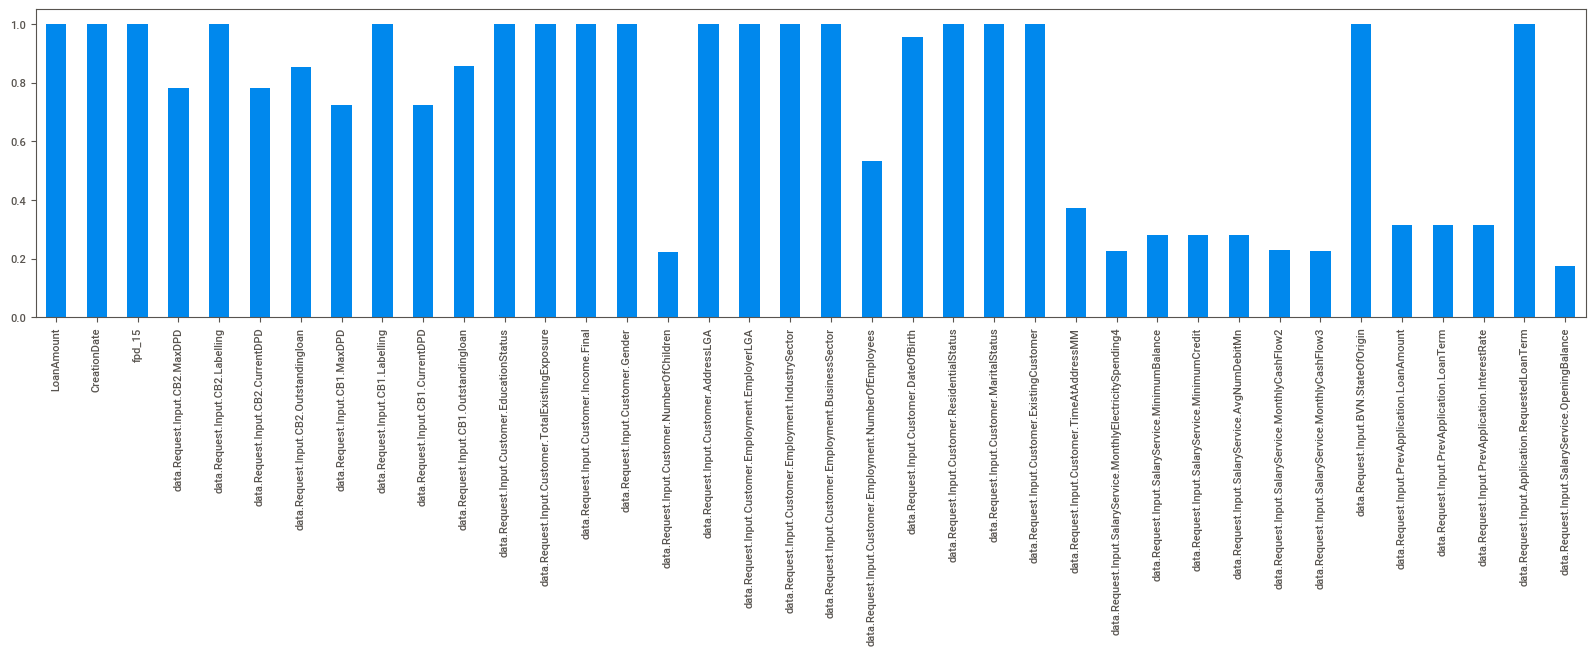

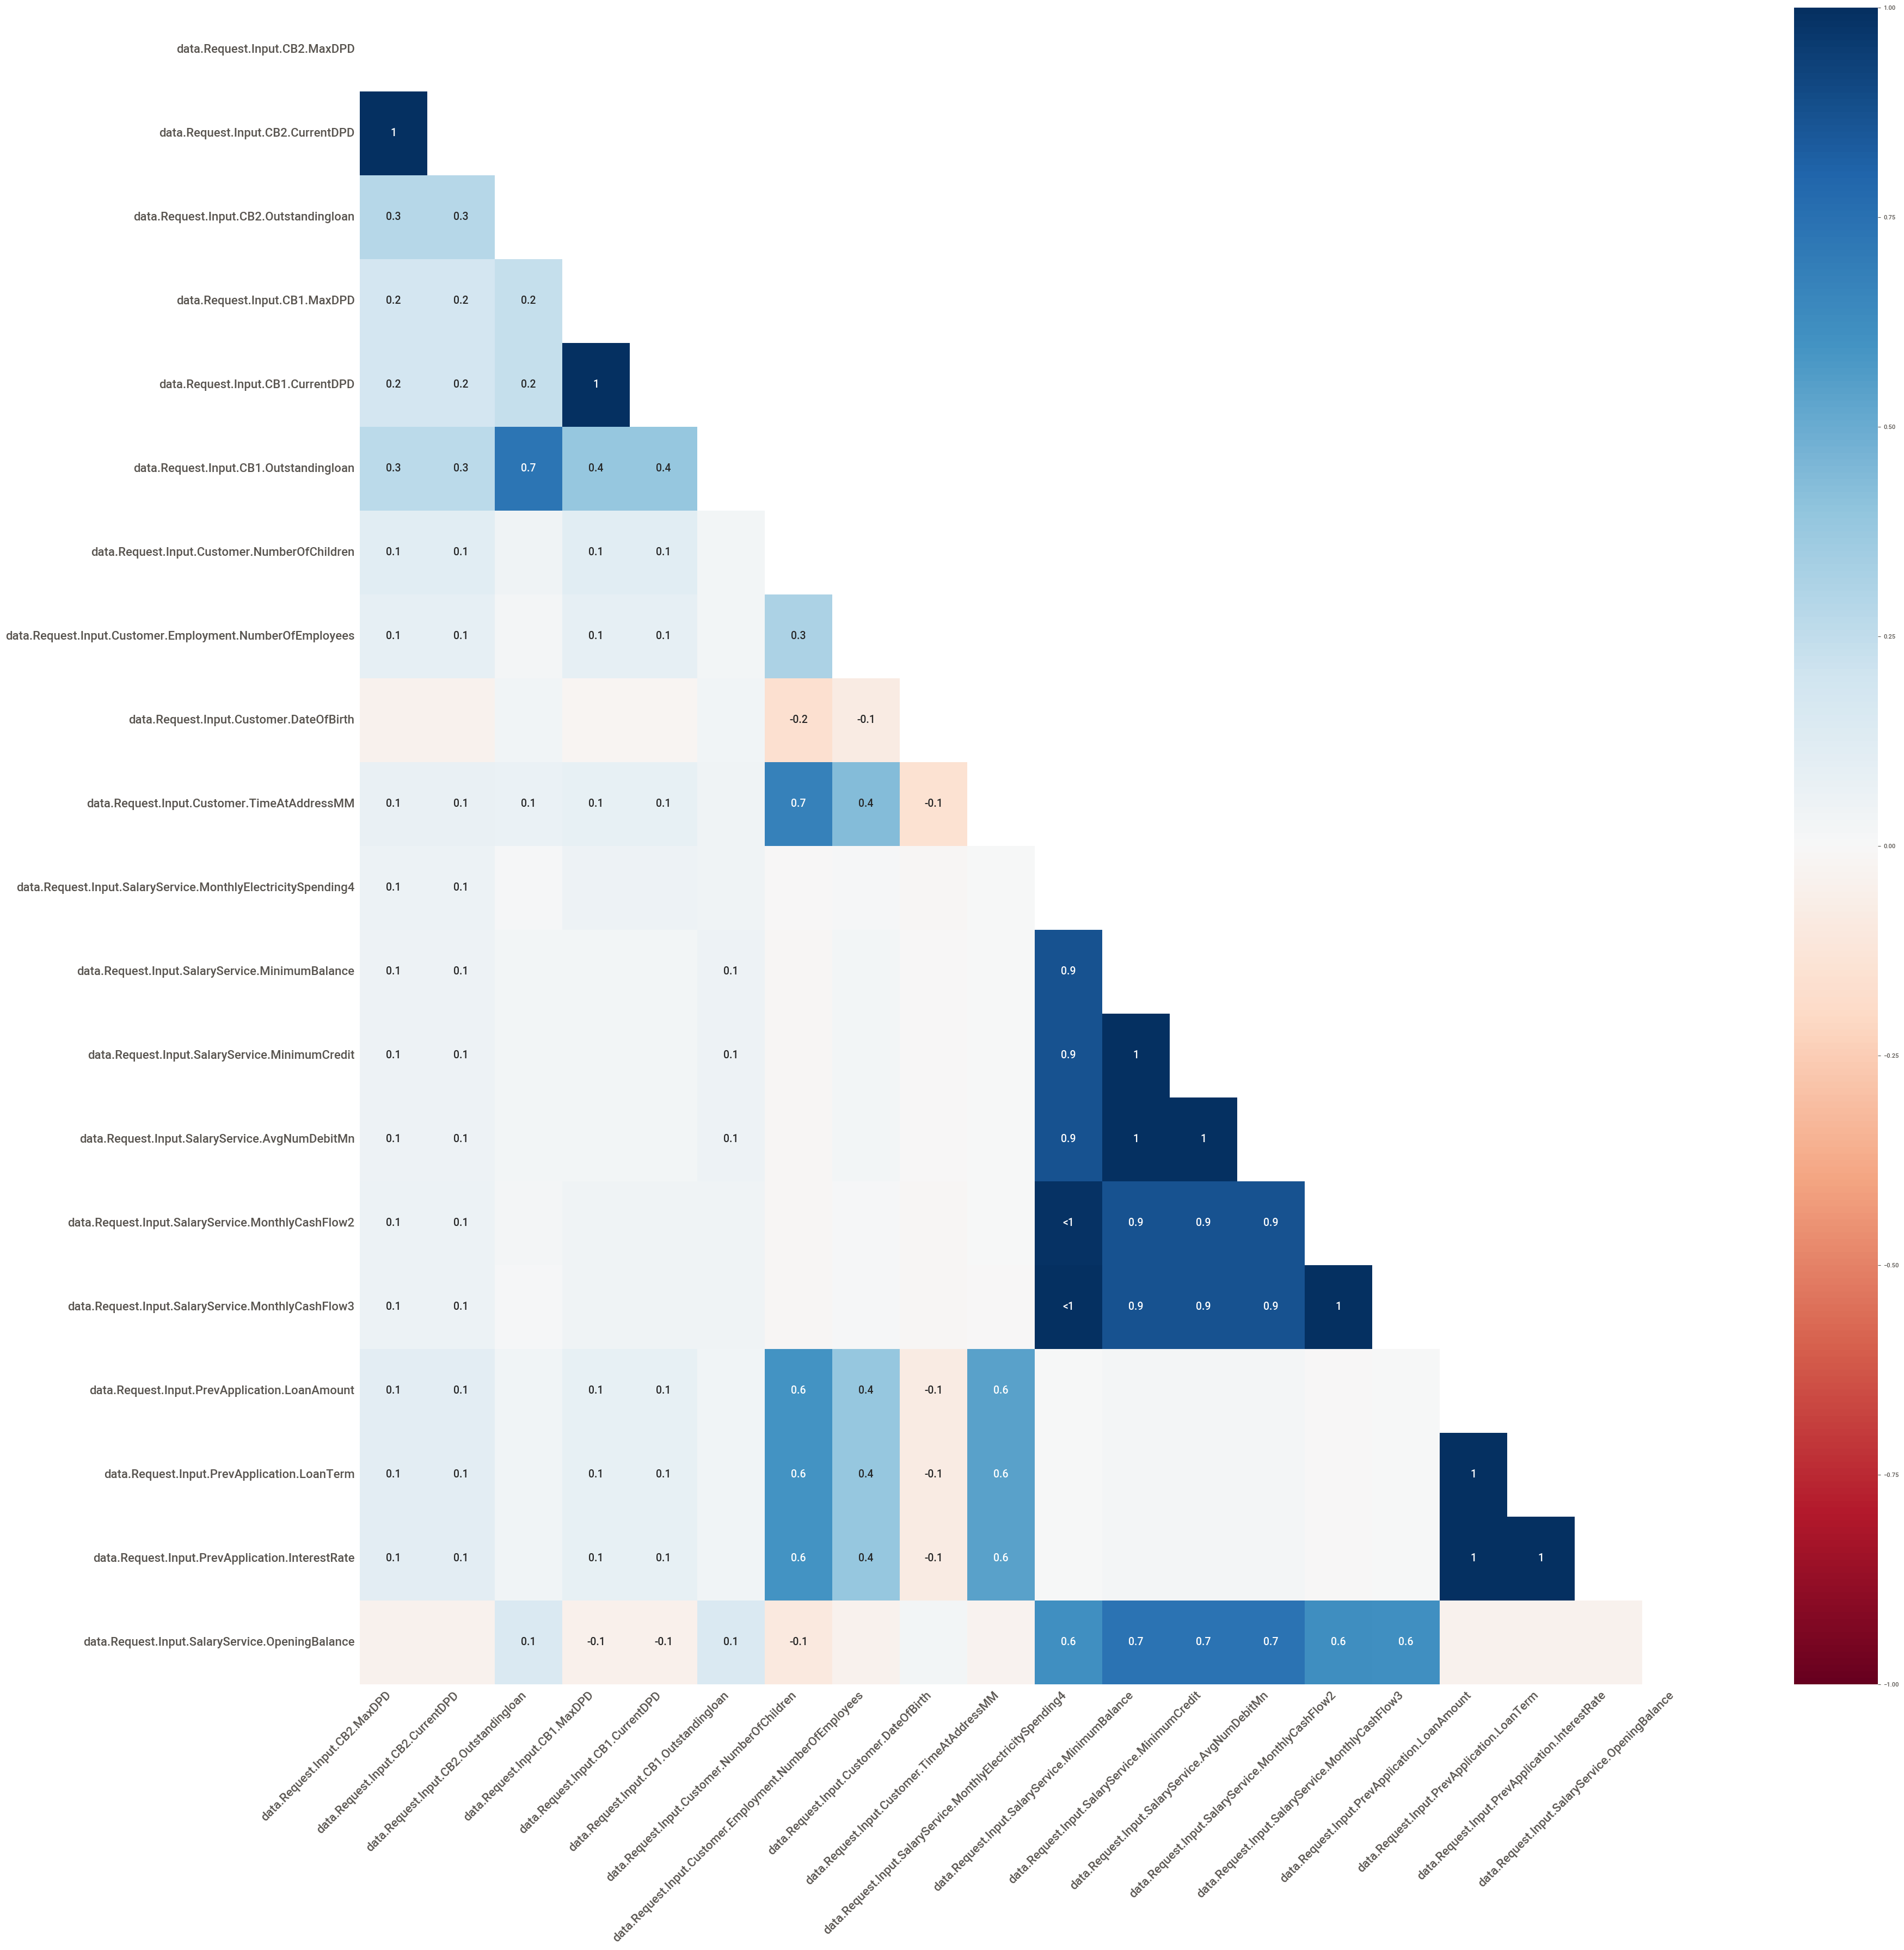

In [10]:
#restore the original df column names for the analysis
df = orig_df

#print the % of missing values
print(df.isnull().mean().sort_values(ascending=False) * 100)

#plot a bar chart of value counts
fig, ax = plt.subplots(figsize=(20, 4))
(1 - df.isnull().mean()).abs().plot.bar(ax=ax)

#export the missing data bar plot
fig.savefig("../images/missing_data_bar.png", dpi=300)

#plot a heatmap showing correlation of missing values
ax = msno.heatmap(df, figsize=(40, 40))

#export the missing data heat plot
fig.savefig("../images/missing_data_heat.png", dpi=300)

# Handle missing data
## Credit Bureau data
The credit bureau data seems to have a missing data rate of between 14% and 27%. Because the credit bureau data comes from two sources (CB1 and CB2) that represent the same information (customer credit history), I have opted to merge them by taking the maximum value between the data provided by each credit bureau. This dropped the credit bureau missing data rate from to between 9% and 11%.

## Salary data and Previous application data
The data from the bank statement (SalaryService) and from previous loan application (PrevApplication) have a very high missing data rate (between 68% and 82%). Because of the high rates, it might not be wise to fill in this data by imputation (replacing the missing values with their average value or 0). Imputation may introduce an unwanted bias as it would imply that more than half of that attribute is a result of modelling rather than observation. Ideally, if the reason for the missing data was known, an appropriate imputation strategy could be formulated. Instead, I have opted to drop these attributes from the dataset. I have specifically dropped columns with missing rates more than 30%. But before dropping these columns, I have created indicator columns (columns that indicate if another column has a missing value for an observation) which could be informative to the loan default problem. Because the missing data from 'PrevApplication' fields are highly correlated (> 90%), I have used 'PrevApplication.LoanAmount' as a proxy for these fields when creating an indicator column. Similarly, I have used the 'SalaryService.MinimumBalance' field as a proxy in the case of the 'SalaryService' fields.

The new dataset now has a missing data rate of between 4% and 11%. In a later code block, I will perform imputation on these.

In [12]:
#combine the current_DPD and max_DPD fields from the two credit bureaus
df['data.Request.Input.CB.CurrentDPD'] = df[['data.Request.Input.CB1.CurrentDPD', 'data.Request.Input.CB2.CurrentDPD']].max(axis=1)
df['data.Request.Input.CB.MaxDPD'] = df[['data.Request.Input.CB1.MaxDPD', 'data.Request.Input.CB2.MaxDPD']].max(axis=1)
df = df.drop(columns = ['data.Request.Input.CB1.MaxDPD', 'data.Request.Input.CB2.MaxDPD','data.Request.Input.CB1.CurrentDPD', 'data.Request.Input.CB2.CurrentDPD'])

#combine the outstanding loan fields from the two credit bureaus
df['data.Request.Input.CB.Outstandingloan'] = df[['data.Request.Input.CB1.Outstandingloan', 'data.Request.Input.CB2.Outstandingloan']].max(axis=1)
df = df.drop(columns = ['data.Request.Input.CB1.Outstandingloan', 'data.Request.Input.CB2.Outstandingloan'])

#create indicator columns for the 'PrevApplication' and 'SalaryService' fields
df['previousApplication'] = df['data.Request.Input.PrevApplication.LoanAmount'].apply(lambda x: 0 if np.isnan(x) else 1)
df['salaryService'] = df['data.Request.Input.SalaryService.MinimumBalance'].apply(lambda x: 0 if np.isnan(x) else 1)

#show the new and retained fields, and their missing data rates
missing_fractions = df.isnull().mean().sort_values(ascending=False)
keep_list = sorted(list(missing_fractions[missing_fractions < 0.3].index))
df = df[keep_list]
print(df.isnull().mean().sort_values(ascending=False) * 100)

data.Request.Input.CB.Outstandingloan                    11.267606
data.Request.Input.CB.CurrentDPD                          9.389671
data.Request.Input.CB.MaxDPD                              9.389671
data.Request.Input.Customer.DateOfBirth                   4.335819
CreationDate                                              0.000000
data.Request.Input.Customer.Employment.IndustrySector     0.000000
previousApplication                                       0.000000
fpd_15                                                    0.000000
data.Request.Input.Customer.TotalExistingExposure         0.000000
data.Request.Input.Customer.ResidentialStatus             0.000000
data.Request.Input.Customer.MaritalStatus                 0.000000
data.Request.Input.Customer.Income.Final                  0.000000
data.Request.Input.Customer.Gender                        0.000000
data.Request.Input.Customer.ExistingCustomer              0.000000
data.Request.Input.Customer.Employment.BusinessSector     0.00

# Preprocessing

## Handling date features
There are two date features in the dataset, the creation date and the date of birth. Because date features cannot be utilised by an ML model as is, I have decided to convert them to numerical values that represent the age of the loan and the customer age in months. Sometimes experiments and lapses in loan decisoning may occur over time period which then skews default rate. Having the loan age in months makes it easier for a model to capture this possibility.

### Assumptions:
1) I have assumed that the 'CreationDate' attribute refers to the date in which the loan was granted. 
2) I have assumed that the dataset is a snapshot of the loan defaults/non-defauls at a particular point in time since they were taken


In [14]:
#define a function to calculate age in months given a date
def calculate_age(df, date_column, new_column_name):
    #create empty iterables to calculated converted values
    ages_in_months = []
    birth_months = []
    #loop through the dates and calculate the ages
    for i in range(len(df)):
        date_value = df[date_column].iloc[i]
        #extract the date value if datetime
        if isinstance(date_value, str):
            date_value = datetime.strptime(date_value, '%Y-%m-%d').date()
        #extract the date value if str
        if isinstance(date_value, datetime):
            date_value = date_value.date()
        #if the date value is not missing and is valid, calculate the age
        if pd.notna(date_value):
            current_date = datetime.now().date()
            delta_years = current_date.year - date_value.year
            delta_months = current_date.month - date_value.month
            age_in_months = delta_years * 12 + delta_months
            ages_in_months.append(age_in_months)
        #if the date value is missing or invalid, use NaN
        else:
            ages_in_months.append(np.nan)
    #create a new column in the dataframe and populate it with the age values
    df[new_column_name] = pd.Series(ages_in_months)
    #drop the date column as it is no longer useful
    df = df.drop(columns=[date_column])
    return df

#Convert the loan creation date to loan age, and the customer date of birth to customer age
df = calculate_age(df, 'CreationDate', 'loanAge')
df = calculate_age(df, 'data.Request.Input.Customer.DateOfBirth', 'data.Request.Input.Customer.Age')



# Data cleaning: uniform format for state of origin
I noticed that the state of origin column has 47 distinct values (46 states and 1 'other'). This is much more than the 37 expected (36 states of Nigeria and 1 'other'). Upon investigation, I noticed that some of the states e.g. lagos appears twice: once in lowercase and again in uppercase. I decided to convert these values into lower case. This reduced the unique count to 37 as expected.

In [16]:
#display the current number of unique states in the state of origin column
print("no. of states before cleaning:", len(df['data.Request.Input.BVN.StateOfOrigin'].unique()))
#convert all state names to lower case
df['data.Request.Input.BVN.StateOfOrigin'] = df['data.Request.Input.BVN.StateOfOrigin'].str.lower()
#display the new number of unique states in the state of origin column
print("no. of states after cleaning:", len(df['data.Request.Input.BVN.StateOfOrigin'].unique()))

no. of states before cleaning: 45
no. of states after cleaning: 37


# Set Fetaures and Target attributes

The target column 'fpd_15' is written to a seperate pandas Series and the feature columns are separated into numerical and categorical for further processing

### Assumptions:
1) I have assumed that fpd_15 refers to first payment default 15 days past due i.e. indicative of loan default. THis is because, of all the attributes, it is the closest in meaning to loan default.

In [18]:
#create a new dataframe to store only the features
features = df.drop(columns = 'fpd_15')
#create a pandas series to store the target variable
target = df['fpd_15']
target.name = 'target'

#retrieve the names of the numerical features
numerical_feature_names = features.select_dtypes(
    include="number"
).columns
#retrieve the names of the categorical features
categorical_feature_names = features.drop(columns = numerical_feature_names).columns

#store the index for possible future use
index = df.index
#dislpay the features
features.head()

,LoanAmount,data.Request.Input.Application.RequestedLoanTerm,data.Request.Input.BVN.StateOfOrigin,data.Request.Input.CB.CurrentDPD,data.Request.Input.CB.MaxDPD,data.Request.Input.CB.Outstandingloan,data.Request.Input.CB1.Labelling,data.Request.Input.CB2.Labelling,data.Request.Input.Customer.AddressLGA,data.Request.Input.Customer.EducationStatus,...,data.Request.Input.Customer.ExistingCustomer,data.Request.Input.Customer.Gender,data.Request.Input.Customer.Income.Final,data.Request.Input.Customer.MaritalStatus,data.Request.Input.Customer.ResidentialStatus,data.Request.Input.Customer.TotalExistingExposure,previousApplication,salaryService,loanAge,data.Request.Input.Customer.Age
0,1350000.0,18.0,kaduna state,0.0,0.0,100000.0,NTC,Prime,Lagos Island,HND,...,0,1,13621000.0,Single,Owner,2142000.0,0,0,11,NaN
1,670000.0,17.0,abia state,0.0,0.0,40000.0,NTC,Prime,Ijebu North,Secondary,...,0,0,479000.0,Widowed,Renting,894000.0,0,1,13,430.0
2,5410000.0,16.0,taraba state,0.0,0.0,20000.0,Prime,Prime,Agege,Graduate,...,1,0,52361000.0,Widowed,Owner,4933000.0,1,0,11,512.0
3,110000.0,14.0,jigawa state,0.0,0.0,0.0,NTC,Sub-Prime,Abeokuta North,Secondary,...,1,0,1316000.0,Single,Owner,203000.0,1,0,13,357.0
4,180000.0,10.0,ogun state,0.0,0.0,170000.0,Prime,Sub-Prime,Mushin,HND,...,0,0,1238000.0,Single,With Friends,193000.0,0,0,15,509.0


# Preprocessing: Imputation
To account for the missing rate of 4% - 11% on the remaining numerical attributes, I have used mean imputation. This should not be too troublesome as it is only being done on a very small portion of the data (three columns and a maximum of 11% of observations). It will prevent information loss caused by discarding entire observations with missing data for these attributes


In [20]:
#impute the remainng missing values of the numerical features with their means and preview the numerical features
numerical_means = features[numerical_feature_names].mean()
features[numerical_feature_names] = features[numerical_feature_names].fillna(numerical_means)
features[numerical_feature_names].head()

,LoanAmount,data.Request.Input.Application.RequestedLoanTerm,data.Request.Input.CB.CurrentDPD,data.Request.Input.CB.MaxDPD,data.Request.Input.CB.Outstandingloan,data.Request.Input.Customer.ExistingCustomer,data.Request.Input.Customer.Gender,data.Request.Input.Customer.Income.Final,data.Request.Input.Customer.TotalExistingExposure,previousApplication,salaryService,loanAge,data.Request.Input.Customer.Age
0,1350000.0,18.0,0.0,0.0,100000.0,0,1,13621000.0,2142000.0,0,0,11,443.713626
1,670000.0,17.0,0.0,0.0,40000.0,0,0,479000.0,894000.0,0,1,13,430.000000
2,5410000.0,16.0,0.0,0.0,20000.0,1,0,52361000.0,4933000.0,1,0,11,512.000000
3,110000.0,14.0,0.0,0.0,0.0,1,0,1316000.0,203000.0,1,0,13,357.000000
4,180000.0,10.0,0.0,0.0,170000.0,0,0,1238000.0,193000.0,0,0,15,509.000000


# Data Cleaning: Outlier Removal
I noticed that the there are also outliers in the data provided. For example, 1)the minumum income value is a negative figure, 2)the max days past due is equivalent to more than 100 years, 3)the maximum income value is in the order of a trillion. These are likely to be data capture errors. I have used Local Outlier Factor, a density based outlier detection algorithm to remove such entries. At a contamination level of 1% (i.e. amount allowed considered outliers), it is able to leave reasonable values for the maximum and minimum values of the numerical features without losing too many observations.

In [22]:
num_features = features[numerical_feature_names]

#define a function to find max and min values in DataFrame columns
def max_min_values(df):
    max_values = df.max()
    min_values = df.min()
    result = pd.DataFrame({'Max': max_values, 'Min': min_values})
    return result
    
#display the original max values, min values, and number of observations
print("MAX AND MIN VALUES BEFORE OUTLIER REMOVAL:")
print(max_min_values(num_features))
print("no. of original observations: ", len(num_features))

#use LOF to remove outliers in the numerical features
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
num_features['anomaly'] = lof.fit_predict(num_features)
#use the anomaly column as a mask to eliminate outliers from the features and target sets
features = features[num_features['anomaly'] == 1]
target = target[num_features['anomaly'] == 1]
num_features = num_features[num_features['anomaly'] == 1].drop(columns=['anomaly'])



#display the new max values, min values, and number of observations
print("\n\nMAX AND MIN VALUES AFTER OUTLIER REMOVAL:")
print(max_min_values(num_features))
print("no. of remaining observations: ", len(num_features))

MAX AND MIN VALUES BEFORE OUTLIER REMOVAL:
                                                            Max          Min
LoanAmount                                         6.000000e+06      80000.0
data.Request.Input.Application.RequestedLoanTerm   4.300000e+01          2.0
data.Request.Input.CB.CurrentDPD                   4.060000e+03          0.0
data.Request.Input.CB.MaxDPD                       4.474200e+04          0.0
data.Request.Input.CB.Outstandingloan              5.686400e+08          0.0
data.Request.Input.Customer.ExistingCustomer       1.000000e+00          0.0
data.Request.Input.Customer.Gender                 1.000000e+00          0.0
data.Request.Input.Customer.Income.Final           6.317924e+12 -189469000.0
data.Request.Input.Customer.TotalExistingExposure  5.992000e+06      82000.0
previousApplication                                1.000000e+00          0.0
salaryService                                      1.000000e+00          0.0
loanAge                          

# Split data into training and testing sets
To facilitate machine learning, the data has been split into training and testing sets at an 80:20 ratio. I have opted not to further split the training set into core triaining and validation sets because I will be using k-fold Cross Validation later on. 

In [24]:
# Split the data into train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=seed)

#display the lengths of the training and test data
print("no. of training data: ", len(y_train)) 
print("no. of training data: ", len(y_test)) 


no. of training data:  2867
no. of training data:  717


# Preprocessing: Target encoding
Categorical features cannot be directly utilised by machine learning models. Because of this, I have opted to encode these fetaures in to a numerical format. For this purpose, I have opted for target encoding which replaces the feature values with the percentage of positive class (defaulters) that match that feature value. It is fitted only on the training set and then used to transform both the training and test sets. This is in order to prevent information leakage from the test set into the training set. Alternative methods include: frequency encoding, and one-hot encoding. I have opted for target encoding because if the dataset is homogeneous (which it is assumed to be as training and test sets are randomly picked), it captures a lot of useful information in informing model formation. It also does not create a overly wide dataset which one-hot encoding tends to do on high cardinality features.

In [26]:
#create an empty dictionary to store fitted target encoders for the different categorical features
te = {}

#loop throught the categorical features, fit the encoder, transform the training and test sets
features_to_encode = categorical_feature_names
for feature in features_to_encode:
    target_encoder = TargetEncoder()
    #fit the encoder on the training and transform it
    X_train[feature] = target_encoder.fit_transform(X_train[feature],y_train)
    #transform the test set with the fitted encoder
    X_test[feature] = target_encoder.transform(X_test[feature])
    #store the encoder for future use
    te[feature] = target_encoder
    

# Preporcessing: Class Imbalance
The number of non-defaulters is 24% more than the number of defaulters in the dataset. This introduces a class imbalance which causes a bias towards the majority class in model building. In order to prevent this bias, I have opted to balance the classes by random oversampling. Alternative methods include underdampling, and SMOTE (a model based method). I have opted for random oversampling because it retains all samples from the majority class (against undersampling) and does not rely on a model which may introduce its own bias to the dataset (against SMOTE).

In [28]:
#assess the class imbalance before oversampling
print("BEFORE OVERSAMPLING")
print("no. of defaulters: ", len(y_train[y_train== 1] ))
print("no. of non-defaulters: ", len(y_train[y_train== 0] ))
print("percentage of defaulters in dataset: ", len(y_train[y_train == 1])/ len(y_train) * 100, "%")

#oversample the minority class
oversampler = RandomOverSampler(random_state=seed)
X_train_over, y_train_over = oversampler.fit_resample(X_train,y_train)

#assess the class imbalance after oversampling
print("\nAFTER OVERSAMPLING")
print("no. of defaulters: ", len(y_train_over[y_train_over== 1]))
print("no. of non-defaulters: ", len(y_train_over[y_train_over== 0]))
print("percentage of defaulters in dataset: ", len(y_train_over[y_train_over == 1])/ len(y_train_over) * 100, "%")

BEFORE OVERSAMPLING
no. of defaulters:  1279
no. of non-defaulters:  1588
percentage of defaulters in dataset:  44.61109173351936 %

AFTER OVERSAMPLING
no. of defaulters:  1588
no. of non-defaulters:  1588
percentage of defaulters in dataset:  50.0 %


# Preprocessing: Imputation for categorical features
Now that the categorical features have been target encoded into numerical values, I perform mean imputation in case of any missing values in these features similarly to what was done for the numerical variables. This is a failsafe and perhaps redundant step as these shouldn't have any missing values if they were successfully target encoded.

In [30]:
#impute missing encoded categorical values with the means of the columns from the training set
categorical_means = X_train_over[categorical_feature_names].mean()
X_train_over[categorical_feature_names] = X_train_over[categorical_feature_names].fillna(categorical_means)
X_test[categorical_feature_names] = X_test[categorical_feature_names].fillna(categorical_means)

# Preprocessing: Standardisation
In this step, I standardise the data. Standardisation involves scaling the feature values to zero mean and unit variance. This is done so that the scale of each feature is similar. It has the effect of improving certain models like distance based models (K-Nearest Neighbours) and regression based models (Logistic Regression). Because these models are candidates for selection, standardisation will help boost their performance. The scaler is fitted only on the tarining data and this fit is used to transform both the training data and the test data. I have restored the binary features to their original form because standardisation is not needed in these cases and may actually cause information loss in some models.

In [32]:
#standardise the training set by fitting a scaler and using it to transform the training data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_over))
X_train_scaled.columns = X_train_over.columns
X_train_scaled.index = X_train_over.index
#binary features can get messed up when scaled. Replace them with their original values.
X_train_scaled['salaryService'] = X_train_over['salaryService'] 
X_train_scaled['previousApplication'] = X_train_over['previousApplication']
X_train_scaled['data.Request.Input.Customer.ExistingCustomer'] = X_train_over['data.Request.Input.Customer.ExistingCustomer']
X_train_scaled['data.Request.Input.Customer.Gender'] = X_train_over['data.Request.Input.Customer.Gender']

#standardise the test set by transforming it with the scaler fitted on the training set
X_test_scaled = pd.DataFrame(scaler.transform(X_test))
X_test_scaled.columns = X_test.columns
X_test_scaled.index = X_test.index
#binary features can get messed up when scaled. Replace them with their original values.
X_test_scaled['salaryService'] = X_test['salaryService'] 
X_test_scaled['previousApplication'] = X_test['previousApplication']
X_test_scaled['data.Request.Input.Customer.ExistingCustomer'] = X_test['data.Request.Input.Customer.ExistingCustomer']
X_test_scaled['data.Request.Input.Customer.Gender'] = X_test['data.Request.Input.Customer.Gender']

# Model Building: Model selection
In this next step, I train different classes of machine learning models (based on different algorithms) on their default values to determine the best type to use for the analysis. Among these models, I include a random guess dummy model as a baseline to determine if there is any predictability from the feature set. I use 4-fold cross validation (4-fold so that the validation sets and the test set are of the same size 20% = 25% of 80%). I compare the mean CV score, the standard deviation, and ratio between them to determine which model is best to move forward with. In this case, I am using the accuracy as the metric to optimise because the dataset is balanced and there is no disclosed trade-off advantage between the positive and negative classes. All models far outperform the dummy model, indicationg that the feature set has predictability. The Random Forest Model shows the most promise with a the highest mean CV score and a low standard deviation.


DUM: score - 0.420655 stdev - (0.047651) ratio- 8.827766
LR: score - 0.751259 stdev - (0.008186) ratio- 91.769231
LDA: score - 0.744962 stdev - (0.008928) ratio- 83.442386
KNN: score - 0.693955 stdev - (0.011577) ratio- 59.940898
DT: score - 0.721033 stdev - (0.031618) ratio- 22.804422
NB: score - 0.723866 stdev - (0.011418) ratio- 63.398078
NN: score - 0.761650 stdev - (0.021547) ratio- 35.348728
AB: score - 0.759446 stdev - (0.009633) ratio- 78.838686
GBM: score - 0.782431 stdev - (0.003604) ratio- 217.115458
XBG: score - 0.791562 stdev - (0.026576) ratio- 29.785392
RF: score - 0.810768 stdev - (0.017000) ratio- 47.693364


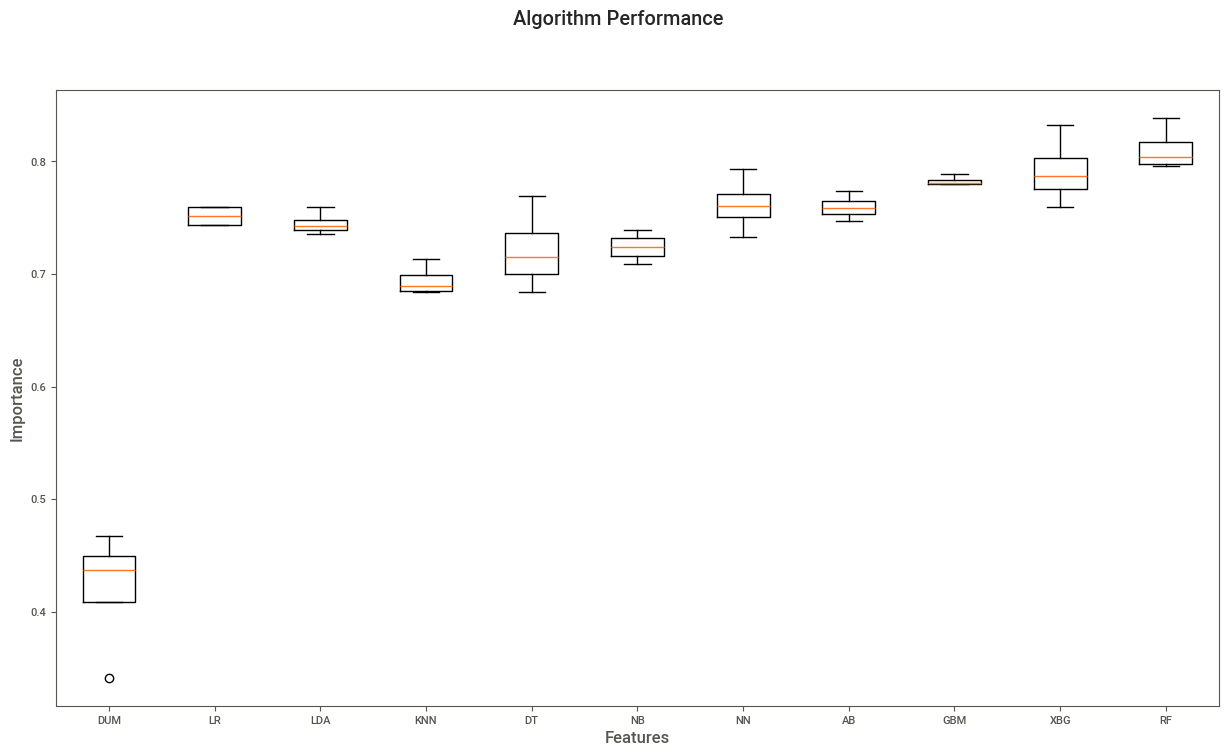

In [34]:
#populate a list with initialised models
models = []
models.append(('DUM', DummyClassifier()))
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('NN', MLPClassifier()))
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
models.append(('XBG', XGBClassifier()))
models.append(('RF', RandomForestClassifier()))

#set the k-fold cross validation parameters
num_folds = 4
scoring = 'accuracy'
#scoring ='precision'
#scoring ='recall'
#scoring = 'roc_auc'

#declare emoty iterables to store model names and their results for comparison
results = []
names = []
#loop through the models and perform k-fold cross validation
for name, model in models:
    #define the kfold CV according to specification and run it for the select model
    kfold = KFold(n_splits=num_folds, shuffle=False)
    cv_results = cross_val_score(model, X_train_scaled, y_train_over, cv=kfold, scoring=scoring)
    #append the CV scores to the results list and display them
    results.append(cv_results)
    names.append(name)
    msg = "%s: score - %f stdev - (%f) ratio- %f" % (name, cv_results.mean(), cv_results.std(), cv_results.mean()/cv_results.std() )
    print(msg)

#plot and compare the models using a box-plot
fig = pyplot.figure()
fig.suptitle('Algorithm Performance')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
# Name the axes
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
pyplot.show()

#export the target algorithms performance plot
fig.savefig("../images/algo_performance.png", dpi=300)

# Feature Selection: Correlation screening cross validation
The dataset has many features relative to the number of observations. This may lead to overfitting which affects model performance out of sample. Some features may contribute more noise than signal to the machine learning model. In order to reduce this, one method is correlation screening. In this case, I screen the features to eliminate those that are least correlated with the target variable. In order not to eliminate too many features, I built and cross-validated a model for a set of correlation thresholds and compared the results. Screening out features with less than 5% correlation resulted in the best model. Although the difference in performance is small compared to using all the features, removing unneccessary features is in line with with the principle of Occam's razor and helps achieve a higher level of model parsimony (robustness).

Threshold: 0.0
Number of features: 23
Mean CV Score: 0.8066750629722921


Threshold: 0.02
Number of features: 20
Mean CV Score: 0.8123425692695214


Threshold: 0.05
Number of features: 18
Mean CV Score: 0.8117128463476071


Threshold: 0.1
Number of features: 13
Mean CV Score: 0.8082493702770781


Threshold: 0.2
Number of features: 3
Mean CV Score: 0.7701511335012594




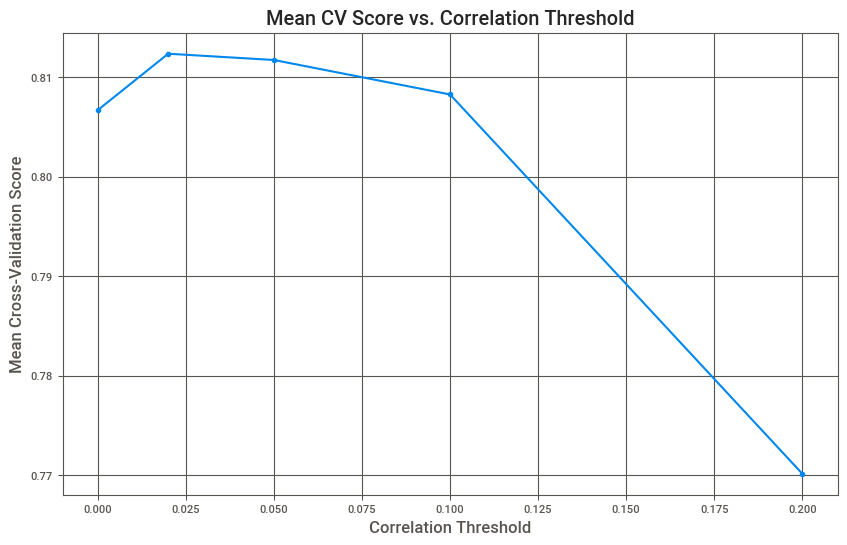

In [36]:
#Define a Function to perform feature selection and cross-validation with target correlation screening
def target_correlation_evaluation(X_train_scaled, y_train_over, thresholds):
    results = {}
    for threshold in thresholds:
        #Combine features and target for correlation calculation
        full_data = pd.concat([X_train_scaled, y_train_over], axis=1)
        correlations = full_data.corr()['target']
        #Identify the uncorrelated features
        uncorrelated_features = []
        for feature in X_train_scaled.columns:
            if np.abs(correlations[feature]) < threshold:
                uncorrelated_features.append(feature)
        #Drop the uncorrelated features
        X_train_corr = X_train_scaled.drop(columns=uncorrelated_features)
        #Initialize a Random Forest model
        model = RandomForestClassifier(random_state=seed)
        #Perform 4-fold cross-validation
        cv = KFold(n_splits=4, shuffle=False)
        cv_scores = cross_val_score(model, X_train_corr, y_train_over, cv=cv, scoring='accuracy')
        #Store the results
        results[threshold] = {
            'num_features': X_train_corr.shape[1],
            'mean_cv_score': np.mean(cv_scores),
            'cv_scores': cv_scores,
            'features': X_train_corr.columns.tolist()
        }
    return results

thresholds = [0.0, 0.02, 0.05, 0.10, 0.20]
results = target_correlation_evaluation(X_train_scaled, y_train_over, thresholds)
#Dsiplay the results
for threshold, result in results.items():
    print(f'Threshold: {threshold}')
    print(f'Number of features: {result["num_features"]}')
    print(f'Mean CV Score: {result["mean_cv_score"]}')
    print("\n")

#Retrieve the threshold values and their accompanying mean scores
thresholds = list(results.keys())
mean_scores = [results[threshold]['mean_cv_score'] for threshold in thresholds]
#plot the mean scores against the threshold values
fig = plt.figure(figsize=(10, 6))
plt.plot(thresholds, mean_scores, marker='o')
plt.xlabel('Correlation Threshold')
plt.ylabel('Mean Cross-Validation Score')
plt.title('Mean CV Score vs. Correlation Threshold')
plt.grid(True)
plt.show()

#export the target correlation screening plot
fig.savefig("../images/target_correlation_screening.png", dpi=300)

# Feature Selection: correlation with target
Following up from the previous code block, I eliminate the features with less than 2% correlation with the target. This leaves 20 features for model building. Before doing so, I save the current feature set for future reference.


In [38]:
#save the current feature set
features_before_selection = X_train_over.columns

#combine the features and the target data and then calculate the correlation of the features with the target
full_data = pd.concat([X_train_scaled, y_train_over], axis = 1)
feature_names = X_train_scaled.columns
correlations = full_data.corr()['target']

#create and empty iterable to store the uncorrelated features
uncorrelated_features = []
#loop through the features and add the features with correlations below the threshold to the iterable
for feature in feature_names: 
    if np.abs(correlations[feature]) <  0.02:
        uncorrelated_features.append(feature)

#create a new training feature set with only the features which pass the correlation screening
X_train_corr = X_train_scaled.drop(columns = uncorrelated_features)
#create a new test feature set with only the features which pass the correlation screening
X_test_corr = X_test_scaled.drop(columns = uncorrelated_features) 

#display the number of features before and after correlation screening
print("the number of features before correlation screening: ", X_train_scaled.shape[1])
print("the number of features after correlation screening: ", X_train_corr.shape[1])
#display the features that were removed
print("\nthe features that were removed: ", uncorrelated_features)


the number of features before correlation screening:  23
the number of features after correlation screening:  20

the features that were removed:  ['data.Request.Input.CB1.Labelling', 'data.Request.Input.Customer.EducationStatus', 'data.Request.Input.Customer.MaritalStatus']


# Feature Selection: correlation between features
Correlation screening can also be used to screen out features that are higly correlated with each other. In some models this may cause multi-collinearity. Random forest can be robust to this but it is better avoided to reduce redundancy and also for accurately assessing feature importance. In this case, the previously created PreviousApplication indicator column is highly correlated with the existing customer column. In fact, they carry the exact same information. Thus, it is screened out.

In [40]:
#set a correlation limit between the features
limit = 0.95
corr = X_train_corr.corr()
#create a mask and use on the correlation matrix so that only one value per feature pair is analysed
mask = np.triu(
    np.ones(corr.shape), k=1
).astype(bool)
corr_no_diag = corr.where(mask)

#identify columns with higher correlation than the threshold limit
#only the first out of the pair will be identified due to the mask
coll = [c for c in corr_no_diag.columns if any(abs(corr_no_diag[c]) > limit)]
print("identified columns: ",coll)

#drop the unwanted column
X_train_corr = X_train_corr.drop(columns= coll)
print("the number of features after correlation screening: ", X_train_corr.shape[1])

identified columns:  ['previousApplication']
the number of features after correlation screening:  19


# Hyperparameter Optimisation
In order to arrive at the best model on the training set (logically, this should also extend to the test set), I perform some hyperparameter optimisation. More specifically, I perform 4-fold cross validation accross a number of different options for the the diffrerent hyperparameters that are relevant to a Random Forest Classifier. I then chose the set of hyperparameters that yield the best model. Because, there are many hyperparameters, and each combination of hyperparamter settings will undergo 4-fold CV, the number of models trained becomes exponential. This process takes a lot of time. Instead, to limit the options for each hyperparameter (the numerical ones in particular), I opted to test a range of values for each hyperparamter separately while leaving the rest at their default values. In deciding which hyperparamters to select, I opted for the set that not only displayed high performance but also low variation between the training and test sets. This is in order to prevent overfitting to the training set.


In [42]:
#define parameters for Grid Search


param_grid = {
    'n_estimators': [80],#range(10,100,10),
    'max_depth': [4],#range(1,10),
    'max_features': [2],#[1, 2, 4, 8, 16],
    'min_samples_split': [2],#[2, 3, 4],#[2, 4, 8, 16],
    'min_samples_leaf': [1],#[1, 2, 4],#[2, 4, 8, 16],
    'class_weight': [{0:1, 1:1.1}],#[{0:1, 1:1},{0:1.1, 1:1},{0:1, 1:1.1},{0:1.2, 1:1},{0:1, 1:1.2}],
    'bootstrap': [True],#[True, False],
    'criterion': ['entropy'],# ['gini','entropy'],
}

#initialize the model
model = RandomForestClassifier()

#setup the grid search
kfold = KFold(n_splits=num_folds, shuffle=False)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, scoring=scoring, n_jobs=-1, verbose=2, return_train_score=True)

#fit the grid search
grid_result = grid.fit(X_train_corr, y_train_over)

#retrieve the results of each of the combinations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
train_means = grid_result.cv_results_['mean_train_score']
train_stds = grid_result.cv_results_['std_train_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
variation = train_means - means
#print the results for each of the combinations
for mean, stdev, train_mean, train_stdev, param, rank, variance in zip(means, stds, train_means, train_stds, params, ranks, variation):
    print("\n#%d Test: %f (%f) Train: %f (%f) with: %r and train-test variation: %f" % (rank, mean, stdev, train_mean, train_stdev, param, variance))
#print the best combination's parameters
print("\nBest: %f using %s" % (grid_result.best_score_, grid_result.best_params_))




Fitting 4 folds for each of 1 candidates, totalling 4 fits

#1 Test: 0.758501 (0.007255) Train: 0.777498 (0.005433) with: {'bootstrap': True, 'class_weight': {0: 1, 1: 1.1}, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 80} and train-test variation: 0.018997

Best: 0.758501 using {'bootstrap': True, 'class_weight': {0: 1, 1: 1.1}, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 80}


# Feature Selection: Recursive Feature Elimination

Now that the best hyperparameters have been selected, the next step is to return to feature selection in order to eliminate any redundant features with the current hyperparamter selection. Recursive Feature Elimination Cross Validation (RFE) is a method which starts by perfoming cross validation on the model using all the features presented and then uses the calculated feature importances to eliminate the least contribting feature. It repeats this process iteratively until only a single feature remains. Then, the cross validation scores can be compared accross the different fetaure selection options. The trend shows an increase in performance as no. of features increased, followed by a flattening and then a slight decrease. In this case, it shows that the optimal number of features is 9. Although similar results were achieved by including more features, adding these features without increasing the amount of data available will likely lead to overfitting.

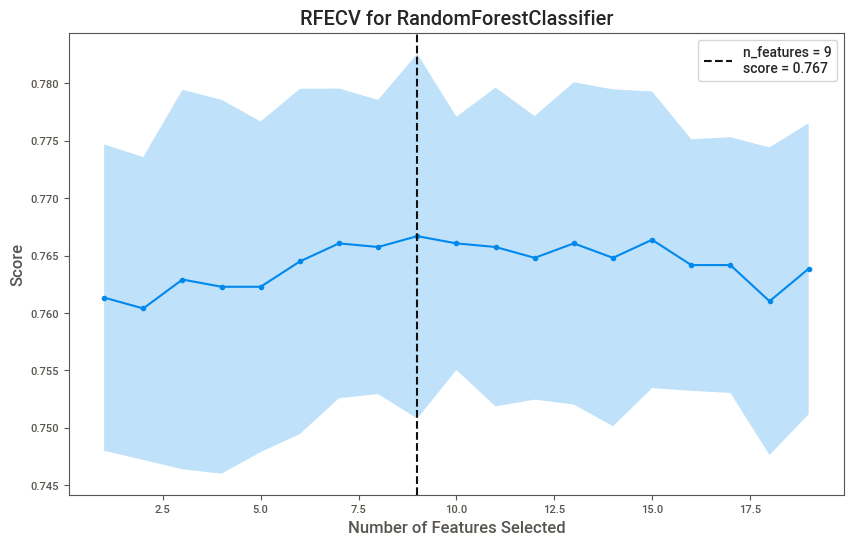

In [44]:
#create a plot to display the CV results for the different feature selections
fig, ax = plt.subplots(figsize=(10, 6))
#perform RFE-CV on the random forest classifier with the optimised hyperparameters
rfe = RFECV(RandomForestClassifier(random_state=seed,
                                   class_weight = {0:1, 1:1.1}, 
                                   max_depth = 4,
                                   n_estimators = 80,
                                   max_features = 2,
                                   bootstrap = True,
                                   criterion = 'entropy',
                                   min_samples_split = 2,
                                   min_samples_leaf = 1,),
            cv=4, step = 1, scoring=scoring);
rfe.fit(X_train_corr, y_train_over)
rfe.rfe_estimator_.ranking_
rfe.rfe_estimator_.n_features_
rfe.rfe_estimator_.support_
rfe.poof()
#export the RFECV plot
fig.savefig("../images/rfecv.png", dpi=300)

# Feature Importance
In this step, I assess the feature importance of the model that has been built. First I use RFE to select the most important features (In this case, 9 of the features left are considered relevant). Then I determine and plot the feature importances on a bar chart.

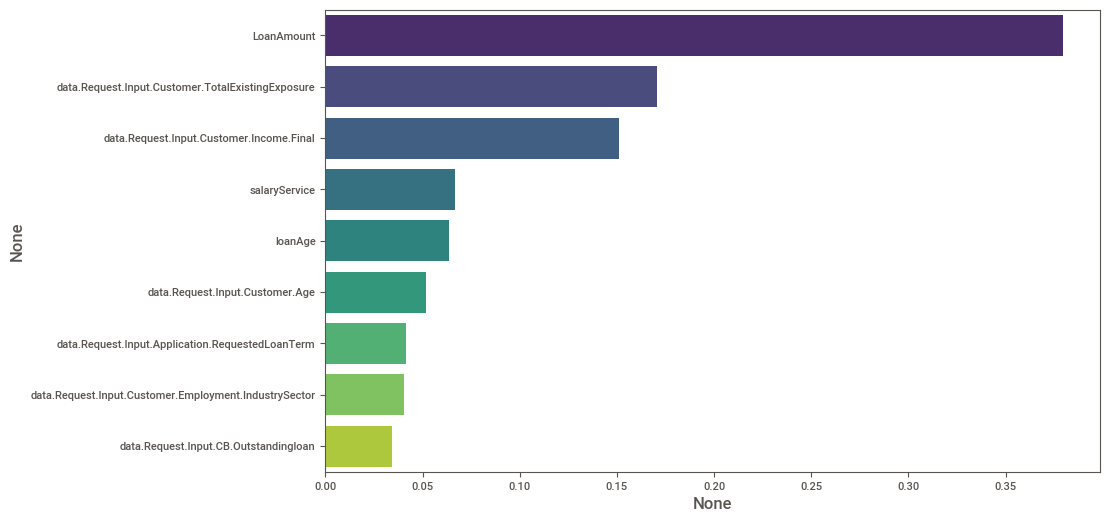

In [46]:
#initialise a random forest classifier with the optimised hyperparameters
model = RandomForestClassifier(random_state=seed,
                               class_weight = {0:1, 1:1.1}, 
                               max_depth = 4,
                               n_estimators = 80,
                               max_features = 2,
                               bootstrap = True,
                               criterion = 'entropy',
                               min_samples_split = 2,
                               min_samples_leaf = 1,)

#perform recursive feature elimination until only 9 features are left
rfe = RFE(estimator=model, n_features_to_select=9)
rfe.fit(X_train_corr, y_train_over)
selected_features = list(X_train_corr.columns[rfe.support_])
#create a new training feature set with only the selected features
X_train_select = X_train_corr[selected_features]
#create a new test feature set with only the selected features
X_test_select = X_test_corr[selected_features]

#train the model on the selected features
model.fit(X_train_select, y_train_over)
#retrieve the feature importance scores for the selected features
importances = model.feature_importances_
feature_importances = pd.Series(importances, index=selected_features).sort_values(ascending=False)

#plot the feature importance scores as a bar chart
fig = plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index, palette='viridis')
# Name the axes
ax.set_xlabel('Importance Score')
ax.set_ylabel('Features')
ax.set_title('Feature Importance Scores')


#export the feature importance plot
fig.savefig("../images/feature_importance.png", dpi=300)

# Test the model on the test set
Now that the model building exercise is concluded. I proceed to test the model on the test set. This will determine if the model has been overfit/underfit during the training process and will assess its readiness to go into production. The test set  has an accuracy score of 78%. This is not too far off from the 77% average on the CV test set and equal to 78% average on the CV train set. Thus, the model generalises well. The results also have a relatively well balanced confusion matrix with a slight tendency to misclassify some non-defaults as defaults, which may be a preferable trade-off in the context of loan default prediction.

In [48]:
#prepare the model with the optimised hyperparameters and feature set
model = RandomForestClassifier(random_state=seed,
                               class_weight = {0:1, 1:1.1}, 
                               max_depth = 4,
                               n_estimators = 80,
                               max_features = 2,
                               bootstrap = True,
                               criterion = 'entropy',
                               min_samples_split = 2,
                               min_samples_leaf = 1,)
model.fit(X_train_select, y_train_over)

#make predictions on the test feature set
predictions = model.predict(X_test_select)

#display the performance metrics for evaluation
print("confusion matrix:\n", confusion_matrix(y_test, predictions))
print("\nclassification report:\n", classification_report(y_test, predictions))
print("Accuracy: ", accuracy_score(y_test, predictions))
print("ROC AUC score: ", roc_auc_score(y_test, predictions))
print("F1-score: ", f1_score(y_test, predictions))
print("Recall: ", recall_score(y_test, predictions))
print("Precision: ", precision_score(y_test, predictions))


confusion matrix:
 [[302  96]
 [ 61 258]]

classification report:
               precision    recall  f1-score   support

           0       0.83      0.76      0.79       398
           1       0.73      0.81      0.77       319

    accuracy                           0.78       717
   macro avg       0.78      0.78      0.78       717
weighted avg       0.79      0.78      0.78       717

Accuracy:  0.7810320781032078
ROC AUC score:  0.7837856996581655
F1-score:  0.7667161961367014
Recall:  0.8087774294670846
Precision:  0.7288135593220338


# Evaluation: ROC Curve
The Receiver-Operator Characteritic (ROC) curve is used to discern how well the model distinguishes between defaulters and non-defaulters. It is a plot of the True positive rate against the false positive rate. The AUC is the area covered by this graph and the gini coefficient is the area between the curve and the digonal. From this curve, the following can be noted:
1) The model significantly outperforms random guessing (AUC/ gini coefficient)
2) It can be visually discerned that the model performs as well on the positive class as on the negative class as their curves are almost identical (ROC curves)
3) The model has an identical trade-off between the true positive rate and the false positive rate (bottom-left compared to top right)

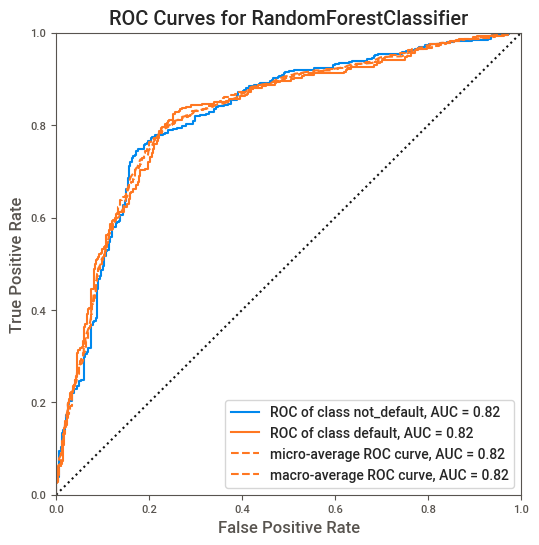

In [50]:
# Create the visualizer
fig, ax = plt.subplots(figsize=(6, 6))
roc_viz = ROCAUC(model, ax=ax, classes=["not_default", "default"])
# Score and visualize the ROC curve
roc_viz.fit(X_train_select, y_train_over)
roc_viz.score(X_test_select, y_test)
roc_viz.show()

#export the ROC curve plot
fig.savefig("../images/roc_curve.png", dpi=300)

# Evaluation: Learning Curve
In order to discern the stability of the model with respect to data availability, the learning curve can be utilised. This shows how the model accuracy changes as more data is added to the **training set** using k-fold cross validation. The learning curve shows that the model overfits the training data when a small amount of data is utilised but as additional data is added its performance is more generalisable to the test data. The learning curve also shows that the CV score is flat even as more data is utilised. This indicates that integrating additional training data will likely not boost the performance of the model out off sample. This is likely because of the feature pruning that was performed. Incorporating additional features may improve performance when additional data is added to the dataset but without additional data it will most likely overfit the training data and not generalise to the test data.

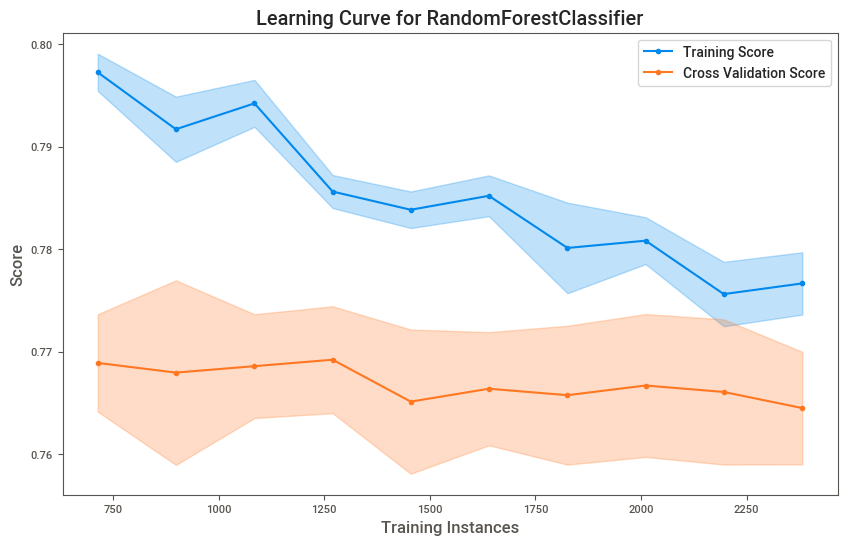

In [52]:
import numpy as np
fig, ax = plt.subplots(figsize=(10, 6))
cv = KFold(4)
sizes = np.linspace(0.3, 1.0, 10)
lc_viz = LearningCurve(
    model,
    cv=cv,
    train_sizes=sizes,
    scoring="accuracy",
    n_jobs=4,
    ax=ax,
)
lc_viz.fit(X_train_select, y_train_over)
lc_viz.poof()

#export the learnning curve plot
fig.savefig("../images/learning_curve.png", dpi=300)

# Export artifacts
Not that the model building exercise is concluded, I proceed to export the artifacts that were generated in the process. These include the random forest model, the standard scaler, the dictionary of target encoders, and the list of selected features.

In [54]:
#export model
joblib.dump(model, "../artifacts/model.joblib")
#export scaler
joblib.dump(scaler, "../artifacts/scaler.joblib")
#export target encoders
joblib.dump(te, "../artifacts/target_encoders.joblib")
#export the list of features before feature selection
joblib.dump(features_before_selection, "../artifacts/features_before_selection.joblib")
#export the lisy of selected features
joblib.dump(selected_features, "../artifacts/selected_features_list.joblib")
#export the means of numerical and categorical features
joblib.dump(numerical_means, "../artifacts/numerical_means.joblib")
joblib.dump(categorical_means, "../artifacts/categorical_means.joblib")

X_train.to_csv('../artifacts/X_train.csv')
X_train_over.to_csv('../artifacts/X_train_oversampled.csv')
X_train_scaled.to_csv('../artifacts/X_train_scaled.csv')
X_train_select.to_csv('../artifacts/X_train_select.csv')
y_train.to_csv('../artifacts/y_train.csv')

X_test.to_csv('../artifacts/X_test.csv')
X_test_scaled.to_csv('../artifacts/X_test_scaled.csv')
X_test_select.to_csv('../artifacts/X_test_select.csv')
y_test.to_csv('../artifacts/y_test.csv')

# Deployment
The exported model can be deplyed on an endpoint. I use the Flask module in python to deploy to host the model on a local server. The model is made available via the 'predict' endpoint. The user simply sends a JSON payload to the endpoint and gets the prediction and the model will generate a prediction and the probability of default. The codeblock below creates the python file that runs the deployment.

In [56]:
%%writefile app.py

#import neccessary modules
from flask import Flask, request, jsonify
import joblib
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import json
from datetime import datetime

#initialise Flask app
app = Flask(__name__)

#loading model
loaded_model = joblib.load("../artifacts/model.joblib")
#loading scaler
loaded_scaler = joblib.load("../artifacts/scaler.joblib")
#loading target encoders
loaded_target_encoders_list = joblib.load("../artifacts/target_encoders.joblib")
#loading the list of features before selection
loaded_features_before_selection = joblib.load("../artifacts/features_before_selection.joblib")
#loading the list of features selected for the model
loaded_selected_features = joblib.load("../artifacts/selected_features_list.joblib")
#loading the means of numerical and categorical features
loaded_numerical_means = joblib.load("../artifacts/numerical_means.joblib")
loaded_categorical_means = joblib.load("../artifacts/categorical_means.joblib")
all_means = pd.concat([loaded_numerical_means, loaded_categorical_means])

#set up 'predict' endpoint and response to POST requests
@app.route('/predict', methods=['POST'])
def predict():
    #extract the features from the request JSON into a python dictionary
    #print(request.json)
    data = json.loads(request.json)
    data = json.loads(data)
    print(data)
    df = pd.DataFrame([data], index=[0], columns = data.keys())
    print(df.columns)
    
    
    df['data.Request.Input.CB.CurrentDPD'] = df[['data.Request.Input.CB1.CurrentDPD', 'data.Request.Input.CB2.CurrentDPD']].max(axis=1)
    df['data.Request.Input.CB.MaxDPD'] = df[['data.Request.Input.CB1.MaxDPD', 'data.Request.Input.CB2.MaxDPD']].max(axis=1)
    df = df.drop(columns = ['data.Request.Input.CB1.MaxDPD', 'data.Request.Input.CB2.MaxDPD','data.Request.Input.CB1.CurrentDPD', 'data.Request.Input.CB2.CurrentDPD'])
    
    #combine the outstanding loan fields from the two credit bureaus
    df['data.Request.Input.CB.Outstandingloan'] = df[['data.Request.Input.CB1.Outstandingloan', 'data.Request.Input.CB2.Outstandingloan']].max(axis=1)
    df = df.drop(columns = ['data.Request.Input.CB1.Outstandingloan', 'data.Request.Input.CB2.Outstandingloan'])
    
    #create indicator columns for the 'PrevApplication' and 'SalaryService' fields
    df['previousApplication'] = df['data.Request.Input.PrevApplication.LoanAmount'].apply(lambda x: 0 if pd.isna(x) else 1)
    df['salaryService'] = df['data.Request.Input.SalaryService.MinimumBalance'].apply(lambda x: 0 if pd.isna(x) else 1)

    #define function to calculate ages from dates
    def calculate_age(df, date_column, new_column_name):
        #create empty iterables to calculated converted values
        ages_in_months = []
        birth_months = []
        #loop through the dates and calculate the ages
        for i in range(len(df)):
            date_value = df[date_column].iloc[i]
            #extract the date value if datetime
            if isinstance(date_value, str):
                date_value = datetime.strptime(date_value, '%Y-%m-%d').date()
            #extract the date value if str
            if isinstance(date_value, datetime):
                date_value = date_value.date()
            #if the date value is not missing and is valid, calculate the age
            if pd.notna(date_value):
                current_date = datetime.now().date()
                delta_years = current_date.year - date_value.year
                delta_months = current_date.month - date_value.month
                age_in_months = delta_years * 12 + delta_months
                ages_in_months.append(age_in_months)
            #if the date value is missing or invalid, use NaN
            else:
                ages_in_months.append(np.nan)
        #create a new column in the dataframe and populate it with the age values
        df[new_column_name] = pd.Series(ages_in_months)
        #drop the date column as it is no longer useful
        df = df.drop(columns=[date_column])
        return df

    #Convert the loan creation date to loan age, and the customer date of birth to customer age
    df = calculate_age(df, 'CreationDate', 'loanAge')
    df = calculate_age(df, 'data.Request.Input.Customer.DateOfBirth', 'data.Request.Input.Customer.Age')

    #convert all state names to lower case
    df['data.Request.Input.BVN.StateOfOrigin'] = df['data.Request.Input.BVN.StateOfOrigin'].str.lower()

    features_before_selection = df[loaded_features_before_selection]
    features_filled = features_before_selection.fillna(all_means)
        
    #target encode the categorical features
    feature_df = pd.DataFrame(features_filled, index = [0])
    te = loaded_target_encoders_list
    for feature_name in feature_df.columns:
        if feature_name in te:
            tx = te[feature_name]
            print(tx)
            feature_df[feature_name] = tx.transform(feature_df[feature_name])
            print(feature_df[feature_name])

    #standardise the features with scaling
    features_df_scaled = pd.DataFrame(loaded_scaler.transform(feature_df), columns = feature_df.columns, index = feature_df.index)
    
    #replace binary features with their original values.
    features_df_scaled['salaryService'] = feature_df['salaryService'] 
    features_df_scaled['previousApplication'] = feature_df['previousApplication']
    features_df_scaled['data.Request.Input.Customer.ExistingCustomer'] = feature_df['data.Request.Input.Customer.ExistingCustomer']
    features_df_scaled['data.Request.Input.Customer.Gender'] = feature_df['data.Request.Input.Customer.Gender']
    
    #remove features not used in the model
    selected_feature_df = features_df_scaled[loaded_selected_features]
    
    #make a prediction
    prediction = loaded_model.predict(selected_feature_df)
    probability = loaded_model.predict_proba(selected_feature_df)
    print("\n\n\n\n",prediction)
    return jsonify({
        'prediction': "1: default" if int(prediction[0]) == 1 else "0: not default",
        'probability of default': float(probability[0][1])
                   })

if __name__ == '__main__':
    app.run(host="127.0.0.1", port=5000,debug=True)


Overwriting app.py


# Run the deployment
To run the deployment, install python and copy the code below, paste and run in command prompt a (windows) or Terminal (Mac/Linux) after navigating to the containing folder. It should create a local deployment on your network using your PC as a server

In [58]:
#python app.py

# Test the deployment
The script below tests the deployment. It reads a random row from the original dataset and performs the same data cleaning, pre-processing, and feature engineering that was used in building the model. It then calls the model's endpoint with the processed features. The endpoint should respond with a JSON containing the prediction and the probability of default. Uncomment the code to run it after running "python app.py" on Terminal or Command prompt.

In [60]:
'''
import pandas as pd
import random
import requests
import json

# Sample data
# Assuming df is your dataframe
sample_index = random.randint(0, len(orig_df) - 1)  # Ensure the index is within the dataframe length
data = orig_df.iloc[sample_index].to_json()
print("The selected observation is:\n")
print(data)

# Make a POST request to the API
response = requests.post('http://127.0.0.1:5000/predict', json=json.dumps(data))

# Try to print the JSON response if possible
try:
    print("\n")
    print("the prediction is:\n")
    print(response.json())
except requests.JSONDecodeError as e:
    print("Error decoding JSON response:", e)
'''

'\nimport pandas as pd\nimport random\nimport requests\nimport json\n\n# Sample data\n# Assuming df is your dataframe\nsample_index = random.randint(0, len(orig_df) - 1)  # Ensure the index is within the dataframe length\ndata = orig_df.iloc[sample_index].to_json()\nprint("The selected observation is:\n")\nprint(data)\n\n# Make a POST request to the API\nresponse = requests.post(\'http://127.0.0.1:5000/predict\', json=json.dumps(data))\n\n# Try to print the JSON response if possible\ntry:\n    print("\n")\n    print("the prediction is:\n")\n    print(response.json())\nexcept requests.JSONDecodeError as e:\n    print("Error decoding JSON response:", e)\n'